## Create Lemur identification datasets

Idea: Lemur detection model finds most salient bounding box, which will be used as a label.

In [1]:
import sys
if '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages' not in sys.path:
    #sys.path.insert(0, '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src/lib')

import os
import re
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import GroupShuffleSplit 

import _init_paths
from models.model import create_model, load_model
from models.decode import *
from tracking_utils.utils import *
from utils.post_process import ctdet_post_process
from utils.image import get_affine_transform
from models.utils import _tranpose_and_gather_feat
import datasets.dataset as datasets

# MC Mot imports
from collections import defaultdict

/usr/users/vogg/monkey-tracking-in-the-wild/src/lib


In [3]:
model = create_model('hrnet_32', heads =  {'hm': 2, 'wh': 2, 'id': 128, 'reg': 2}, 
                     head_conv = 256, num_gc_cls = 8, clsID4GC = 0, gc_with_roi = False)
model = load_model(model, '../exp/mot/lemurs_full/model_200.pth')
model = model.to(torch.device('cuda'))
model.eval();

{'hm': 2, 'wh': 2, 'id': 128, 'reg': 2}
loaded ../exp/mot/lemurs_full/model_200.pth, epoch 200


In [4]:
path = Path("/usr/users/vogg/Labelling/Lemurs/Individual_imgs")

In [20]:
jpg_list = []

for elem in os.listdir(path):
    if elem == "GroupB": #"." not
        for subelem in os.listdir(path / elem):
            if "." not in subelem:
                for file in os.listdir(path / elem / subelem):
                    if file.endswith(".jpg"):
                        jpg_list.append(path / elem / subelem / file)

                        
                        
weak_labels = []
group_label = []
video = []
for n, img in enumerate(jpg_list):
    group = re.split('/', str(img))[-2]
    vid = re.split('/', str(img))[-1]
    video.append(vid[5:15])
    weak_labels.append(group[2:])
    group_label.append(group[0])
    


### Train-val split

The model should be able to generalize to completely new views. That is why we split by video, so that no video sequence is in train and validation set.

In [28]:
summ = pd.DataFrame({'path' : jpg_list, 'video' : video, 'indiv' : weak_labels, 'group' : group_label})

#only try with alpha for now
summ = summ[summ.group == "B"]

splitter = GroupShuffleSplit(test_size=.10, n_splits=2, random_state = 2) #used 5 for alpha split, 2 for B
split = splitter.split(summ, groups=summ['video'])
train_inds, test_inds = next(split)

train = summ.iloc[train_inds]
test = summ.iloc[test_inds]
print(len(train))
print(len(test))

988
89


In [17]:
#copying all files to one folder
for file in train['path']:
    shutil.copy(str(file), path / "images")
    
for file in test['path']:
    shutil.copy(str(file), path / "eval")

In [18]:
names = sorted(list(set(summ.indiv)))
name_dict = {name : i for i,name in enumerate(names)}
name_dict

{'Amb': 0, 'Har': 1, 'Isa': 2, 'Kai': 3, 'Lat': 4, 'Sap': 5}

In [12]:
i = 0

for i in range(len(test['path'])): #jpg_list
    if i % 100 == 0:
        print(i)
    img0 = cv2.imread(str(list(test['path'])[i]))  # BGR
    img_box, _, _, _ = datasets.letterbox(img0, height=608, width=1088)

    # Normalize RGB
    img = img_box[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img, dtype=np.float32)
    img /= 255.0

    im_blob = torch.from_numpy(img).cuda().unsqueeze(0)

    width = img0.shape[1]
    height = img0.shape[0]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]

    with torch.no_grad():
        output = model(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        reg = output['reg']


    dets, inds, cls_inds_mask = mot_decode(heatmap=hm,
                                               wh=wh,
                                               reg=reg,
                                               num_classes=2,
                                               cat_spec_wh=False,
                                               K=5)
    h_out = inp_height // 4
    w_out = inp_width // 4
    dets = map2orig(dets, h_out, w_out, height, width, 2)

    coords = dets[0][0]

    center = tuple(map(int, ((coords[0] + coords[2]) / 2, (coords[1] + coords[3]) / 2)))
    low_left = tuple(map(int, (coords[0], coords[1])))
    up_right = tuple(map(int, (coords[2], coords[3])))
    w = coords[2] - coords[0]
    h = coords[3] - coords[1]


    label_fpath = (path / 'labels_with_ids' / list(test['path'])[i].name).with_suffix('.txt')

    label_str = '{:d} {:d} {:.6f} {:.6f} {:.6f} {:.6f} {:d}\n'.format(
            0, 0, center[0] / width, center[1] / height, 
        w / width, h / height, name_dict[list(test['indiv'])[i]])


    with label_fpath.open(mode='a') as f:
         f.write(label_str)

0
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aFGen/GX020115_small_1624.jpg
Gen


/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aFGen/GX010115_small_16785.jpg
Gen
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aFGen/GX020115_small_1276.jpg
Gen
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aFGen/GX010115_small_16552.jpg
Gen
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aFGen/a_e_1_220918_c3_9400.jpg
Gen
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aFGen/GX020115_small_2876.jpg
Gen
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aMHer/a_e_1_220918_c2_2977.jpg
Her
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aMHer/GX010172_small_4359.jpg
Her
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aMHer/a_e_1_220918_c3_8597.jpg
Her
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aMHer/a_e_1_220918_c3_8607.jpg
Her
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aMHer/a_e_1_220918_c1_3002.jpg
Her
/usr/users/vogg/Labelling/Lemurs/Individual_imgs/Groupa/aMHer/a_e_1_220918_c3_27839.jpg
Her
/

In [9]:
with (path / 'lemur_ids.train').open('w') as f:
    for i in train['path'].index:
        #for rep in range(10):
        f.write(f'Individual_imgs/images/{train.path[i].name}\n')

The following code is just a test that everything is OK. Because we append each lemur to a new file, it can happen that we introduce duplicates in labels_with_ids if we run it more often. The function below should not output anything. If it outputs something, this means that the folder labels_with_ids should be emptied and the labels should be recreated.

In [15]:
for ip in jpg_list:
    if sum(1 for line in open(path / 'labels_with_ids' / (str(ip.name[:-4]) + ".txt"))) > 1:
        print(ip)

(1289, 637)
(1114, 493)


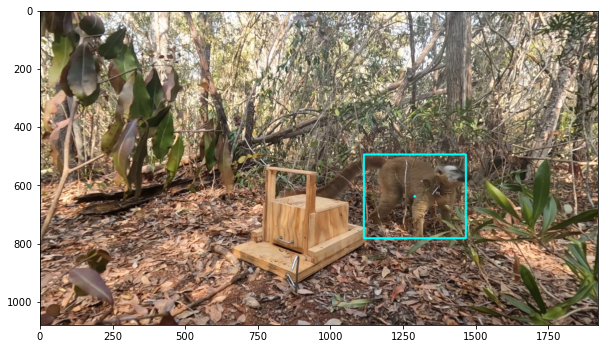

In [387]:
color = (255, 255, 0)
img0 = cv2.circle(img0, center, radius = 2, color = color, thickness = 5)
img0 = cv2.rectangle(img0, low_left, up_right, color = color, thickness = 5)

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))

plt.show()

### Dataset statistics

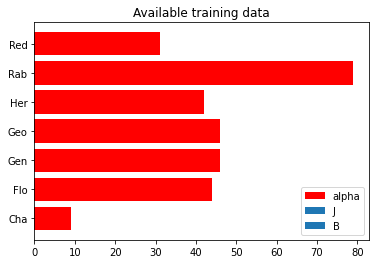

In [20]:
#summ = pd.DataFrame({'video' : video, 'indiv' : weak_labels, 'group' : group_label})
summ = train
count_df = summ.groupby(['group','indiv']).count().reset_index()


plt.barh(count_df[count_df['group'] == "a"]['indiv'], count_df[count_df['group'] == "a"]['video'], 
         color = "red", label = "alpha")
plt.barh(count_df[count_df['group'] == "J"]['indiv'], count_df[count_df['group'] == "J"]['video'], 
         color = "green", label = "J")
plt.barh(count_df[count_df['group'] == "B"]['indiv'], count_df[count_df['group'] == "B"]['video'], 
         color = "blue", label = "B")


plt.title('Available training data')
plt.legend()
plt.show()